# Calibrating deep convolutional neural networks


Neural networks tend to be have a non-trivial, and many times large, gap between mean accuracy and the mean confidence of their predictions. This gap tends to grow with larger modern architectures. 

Following the work of [Guo, 2017](https://arxiv.org/pdf/1706.04599.pdf) we use temperature scaling as a way to obtain calibrated confidence scores for CNNs models for image classification. We use LeNet and ResNet to build two classifiers using the CIFAR-100 dataset. We show how we map the distributions of the raw confidence scores to a different one so that the mean confidence is closer to the accuracy of the model. 

Sections in this notebook:

1. Dataloading.
2. Model training.
3. Calibration of models.
4. Comparison of the models mean confidence before and afte calibration.

In [ ]:
import time
import os
from typing import Optional, Tuple

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50 as resnet_50
from torchvision.models import resnet101 as resnet_101
from torchvision.datasets import CIFAR100, CIFAR10
from torchvision.transforms import (Compose, 
                                    ToTensor, 
                                    RandomAffine,
                                    RandomHorizontalFlip,
                                    Normalize,
                                    RandomCrop)
from torchvision.transforms import InterpolationMode
Loss = torch.nn.modules.loss._Loss
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from google.colab import drive
drive.mount('/content/drive')

MODELS_PATH = '/content/drive/MyDrive/22_vision/10_models/'

Mounted at /content/drive


# Data

In [ ]:
torch.manual_seed(0)

train_transforms = Compose([
                            ToTensor(), 
                            Normalize(mean=(0.5071, 0.4867, 0.4408), 
                                      std=(0.2675, 0.2565, 0.2761)
                                      ),
                            RandomCrop(32, padding=4, padding_mode='reflect'),
                            RandomHorizontalFlip(0.5)
                            ])

test_transforms = Compose([ToTensor(), 
                           Normalize(mean=(0.5071, 0.4867, 0.4408), 
                                      std=(0.2675, 0.2565, 0.2761)
                                      )])

train_ds = CIFAR100('/content', 
              train = True, 
              transform = train_transforms, 
              target_transform = None, download = True)

test_ds = CIFAR100('/content', 
              train = False, 
              transform = test_transforms, 
              target_transform = None, download = True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /content/cifar-100-python.tar.gz to /content
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


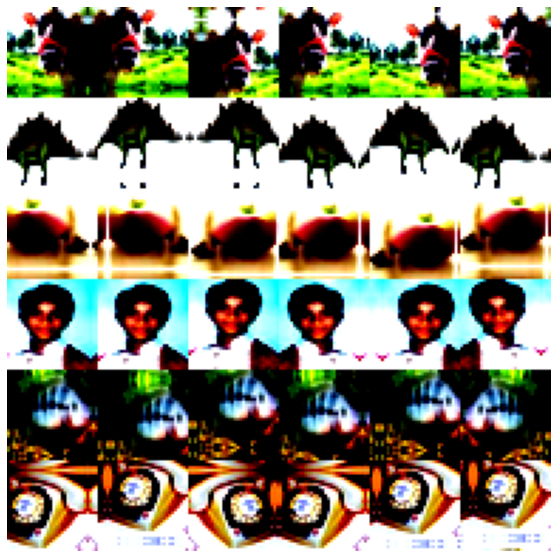

In [ ]:
def show_dataset(dataset, n=6, repeat=False):
    """
    repeat: Set to False to get all different images. Set to True to
        get the same image across the horizontal axis.
    """
    # boolean flag to work with tensors
    is_tensor = isinstance(dataset[0][0], torch.Tensor)
    
    if repeat:
        img = np.vstack(list(np.hstack(list(np.asarray(
            dataset[i][0].permute(1,2,0) if is_tensor else dataset[i][0]) 
        for _ in range(n))) for i in range(n)))
    else:
        img = np.vstack(list(np.hstack(list(np.asarray(
            dataset[j][0].permute(1,2,0) if is_tensor else dataset[j][0]) 
        for j in range(i*n,n*(1+i)))) for i in range(n)))

    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')

show_dataset(train_ds, 6, True)

# Architectures

We use a LeNet and a ResNet in our experiments 

In [ ]:
class LeNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_seq = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
        )
        self.dense_seq = nn.Sequential(
            nn.Linear(576, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_seq(x)
        x = self.dense_seq(x.reshape(x.size(0),-1))
        return x



class ResNet50(nn.Module):
    """
    Modified ResNet for CIFAR-100.
    """

    def __init__(self):
        super().__init__()

        self.resnet50 = resnet_50(pretrained=False)
        # original filter would leave us with 15x15 output
        self.resnet50.conv1 = nn.Conv2d(3, 64, 
                                        kernel_size=3, 
                                        stride=1, padding=1, bias=False)
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, 100, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.resnet50(x)

# Training functions

Functions to execute the optimization and evaluation for each epoch. 

In [ ]:
def train_epoch(train_loader: DataLoader, 
                model: nn.Module, 
                optimizer, criterion: Loss) -> Tuple[float]:
    """
    Executes the forward and backward pass for each batch in one epoch.

    Returns:
        mean_epoch_loss: mean epoch loss.
        mean_acc: mean epoch accuracy.
    """
    model.train()

    train_loss = 0
    correct = 0
    total = 0
    temp = []

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * train_loader.batch_size
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    mean_epoch_loss = train_loss / len(train_loader.dataset)
    mean_acc = 100. * correct / total
    return mean_epoch_loss, mean_acc


def evaluate(val_loader: DataLoader, 
             model: nn.Module, 
             criterion: Loss, 
             name: Optional[str] = None):
    """
    Args:
        name: name to be used in the saving of the model.

    Returns:
        mean_loss: mean loss over the validation dataset.
        mean_acc: mean accuracy over the validation dataset.
    """
    global best_acc
    global epoch
    
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    temp = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * val_loader.batch_size
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    mean_loss = test_loss / len(val_loader.dataset)
    mean_acc = 100. * correct / total

    # Save checkpoint.
    if name is not None:
        if mean_acc > best_acc:
            state = {
                'net': model.state_dict(),
                'acc': mean_acc,
                'epoch': epoch,
            }
            torch.save(state, os.path.join(MODELS_PATH, f'{name}_best_accuracy.pth'))
            best_acc = mean_acc
    return mean_loss, mean_acc

# Training the classifier models

We train the LeNet and ResNet models below.

In [ ]:
BATCH_SIZE = 20
LR = 0.001

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, drop_last=False)

## LeNet

In [ ]:
num_epochs = 70

lenet = LeNet().to(device)
optimizer = Adam(lenet.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

Epoch: 0, Train loss: 3.879, Val loss: 3.520, Train Acc:  10.04, Val acc:  15.87 Epoch time = 24.919s
Epoch: 4, Train loss: 3.035, Val loss: 2.971, Train Acc:  24.87, Val acc:  26.52 Epoch time = 24.089s
Epoch: 8, Train loss: 2.821, Val loss: 2.783, Train Acc:  28.92, Val acc:  30.84 Epoch time = 23.868s
Epoch: 12, Train loss: 2.690, Val loss: 2.700, Train Acc:  31.63, Val acc:  32.65 Epoch time = 23.904s
Epoch: 16, Train loss: 2.590, Val loss: 2.629, Train Acc:  33.64, Val acc:  33.42 Epoch time = 23.971s
Epoch: 20, Train loss: 2.525, Val loss: 2.572, Train Acc:  35.00, Val acc:  35.32 Epoch time = 23.719s
Epoch: 24, Train loss: 2.475, Val loss: 2.567, Train Acc:  36.18, Val acc:  35.55 Epoch time = 24.185s
Epoch: 28, Train loss: 2.439, Val loss: 2.533, Train Acc:  36.54, Val acc:  35.70 Epoch time = 23.966s
Epoch: 32, Train loss: 2.400, Val loss: 2.559, Train Acc:  37.57, Val acc:  36.05 Epoch time = 23.804s
Epoch: 36, Train loss: 2.378, Val loss: 2.516, Train Acc:  37.94, Val acc:  

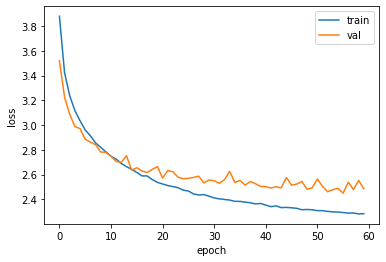

In [ ]:
train_losses, val_losses = [], []
best_acc = -1

for epoch in range(0, num_epochs):
    start_time = time.time()
    train_loss, train_acc = train_epoch(train_loader, lenet, optimizer, loss_fn)
    end_time = time.time()
    val_loss, val_acc = evaluate(test_loader, lenet, loss_fn, 'lenet_cifar100')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if epoch % 4 == 0:
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train Acc: {train_acc : .2f}, Val acc: {val_acc: .2f} "
          f"Epoch time = {(end_time - start_time):.3f}s"))
    

plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(val_losses)), val_losses, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## ResNet

In [ ]:
resnet50 = ResNet50().to(device)

num_epochs = 60

optimizer = Adam(resnet50.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
train_losses, val_losses = [], []
best_acc = -1

for epoch in range(0, num_epochs):
    start_time = time.time()
    train_loss, train_acc = train_epoch(train_loader, resnet50, optimizer, loss_fn)
    end_time = time.time()
    val_loss, val_acc = evaluate(test_loader, resnet50, loss_fn, 'resnet50_cifar100')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if epoch % 4 == 0:
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train Acc: {train_acc : .2f}, Val acc: {val_acc: .2f} "
          f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 0, Train loss: 4.110, Val loss: 3.741, Train Acc:  7.51, Val acc:  15.58 Epoch time = 127.523s
Epoch: 4, Train loss: 2.552, Val loss: 7.132, Train Acc:  33.54, Val acc:  35.30 Epoch time = 125.913s
Epoch: 8, Train loss: 2.012, Val loss: 2.123, Train Acc:  45.71, Val acc:  47.71 Epoch time = 124.697s
Epoch: 12, Train loss: 1.697, Val loss: 7.383, Train Acc:  52.99, Val acc:  48.59 Epoch time = 124.408s
Epoch: 16, Train loss: 1.383, Val loss: 4.071, Train Acc:  60.03, Val acc:  54.43 Epoch time = 124.910s
Epoch: 20, Train loss: 1.291, Val loss: 6.148, Train Acc:  62.55, Val acc:  54.36 Epoch time = 124.594s
Epoch: 24, Train loss: 1.068, Val loss: 2.491, Train Acc:  68.60, Val acc:  57.40 Epoch time = 124.112s
Epoch: 28, Train loss: 0.853, Val loss: 3.685, Train Acc:  74.45, Val acc:  56.38 Epoch time = 125.188s
Epoch: 32, Train loss: 0.727, Val loss: 3.964, Train Acc:  77.73, Val acc:  56.41 Epoch time = 124.334s
Epoch: 36, Train loss: 0.612, Val loss: 4.560, Train Acc:  80.93, Va

# Raw confidences and calibration

`TemperatureScaling` takes a given model and calibrates logits.

In [ ]:
def labels_and_probabilities(test_loader: DataLoader, 
                             model: nn.Module, 
                             device: torch.device
                             ) -> Tuple[torch.tensor, torch.tensor]:
    """
    Gets ground truth labels and predicted multiclass probabilities for the
    given model.

    Args:
       test_loader: dataloader of test samples.
       model: model to test.
       device: torch device.

    Returns:
         outputs: model outputs after softmax is applied, i.e., multiclass 
            probabilities.
        labels: ground truth labels for each data sample.
    """
    
    model.to(device)
    model.eval()

    outputs = []
    labels = []
    with torch.no_grad():
        for (input, label) in test_loader:
            input = input.to(device)
            outputs.append(model(input))
            labels.append(label)
    
    outputs = torch.cat(outputs)
    sm = nn.Softmax(1)
    outputs = sm(outputs)

    labels = torch.cat(labels)

    return outputs, labels


def confidence_hist(
              conf: torch.Tensor, 
              labels: torch.Tensor, 
              title: Optional[str] = None, 
              bins: int = 20,
              alpha: int = 1.0):
    """
    Plots confidence histogram, mean confidence, mean accuracy for given data.

    Args:
        conf: output logits of a model. Size = [num of samples, num of classes]
        labels: ground truth. Size = [num of samples,]
        bins: number of bins for histogram
    """
    
    conf, labels = conf.cpu(), labels.cpu()
    max_conf, _ = conf.max(1)
    max_conf = max_conf.numpy()
    # confidence histogram
    plt.hist(max_conf, bins=bins, weights=np.ones(len(max_conf))/len(max_conf), alpha=alpha) 
    # add line at mean conf
    ymax = max(np.histogram(max_conf, bins=bins)[0])
    plt.vlines(np.mean(max_conf), ymin=0, ymax=1, label="mean confidence")
    # add line at mean accuracy
    acc = ((conf.argmax(1) == labels).sum()/len(labels)).numpy()
    plt.vlines(acc, ymin=0, ymax=1, label="mean accuracy", linestyles='--')
    plt.legend()
    if title:
        plt.title(title)
    plt.xlabel('confidence scores')


class TemperatureScaling(nn.Module):
    """
    Recalibrates a model using temperature scaling.

    Args:
        model: trained model outputing logits.
    """
    def __init__(self, model: nn.Module):

        super().__init__()
        self.model = model
        for p in self.model.parameters():
            p.requires_grad_(False)
        self.t = nn.parameter.Parameter(torch.tensor(1.))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        x = x / self.t
        return x 

We split the test set into two subsets. One of the subsets is used as the training data for the calibrator. Then we use the other subset to test the accuracy of the model before and after calibration.

In [ ]:
# use portion of test data of the raw model to train calibrated version
(scale_train_ds,
 scale_val_ds) = random_split(test_ds, [5000, 5000], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(scale_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(scale_val_ds, batch_size=BATCH_SIZE, drop_last=False)

### Lenet

We train the calibrated version of the LeNet model.

In [ ]:
# load model
lenet = LeNet().to(device)
lenet.load_state_dict(torch.load(
    os.path.join(MODELS_PATH, 'lenet_cifar100_best_accuracy.pth'), 
    map_location=device)['net'])

# instatiate version to calibrate 
lenet_scaled = TemperatureScaling(lenet).to(device)

# train calibrated version
BATCH_SIZE = 20
LR = 0.0001
num_epochs = 10

optimizer = Adam(filter(lambda x: x.requires_grad, lenet_scaled.parameters()), lr=LR)
loss_fn = nn.CrossEntropyLoss()

best_acc = -1
for epoch in range(0, num_epochs):
    start_time = time.time()
    train_loss, train_acc = train_epoch(train_loader, lenet_scaled, optimizer, loss_fn)
    end_time = time.time()
    
    if epoch % 2 == 0:
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train Acc: {train_acc : .2f}"
          f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 0, Train loss: 2.446, Train Acc:  38.46Epoch time = 3.308s
Epoch: 2, Train loss: 2.438, Train Acc:  38.46Epoch time = 1.371s
Epoch: 4, Train loss: 2.432, Train Acc:  38.46Epoch time = 1.390s
Epoch: 6, Train loss: 2.427, Train Acc:  38.46Epoch time = 2.898s
Epoch: 8, Train loss: 2.425, Train Acc:  38.46Epoch time = 1.382s


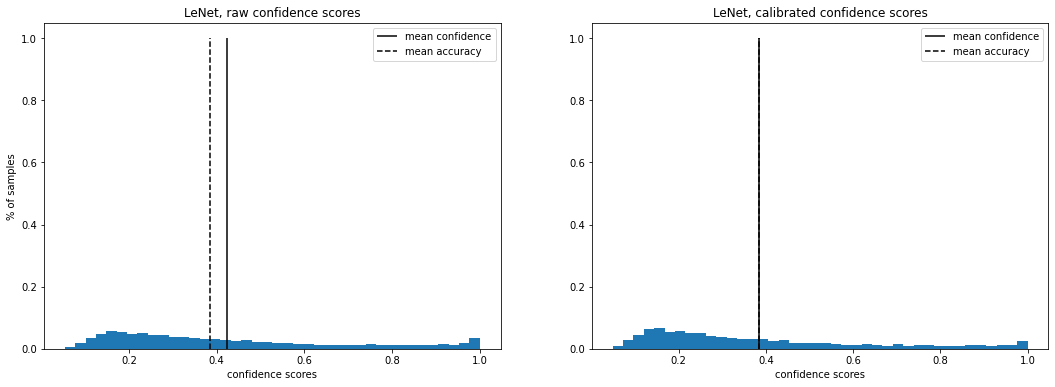

In [ ]:
lenet_confidence, labels = labels_and_probabilities(test_loader, lenet, device)
scaled_lenet_confidence, _ = labels_and_probabilities(test_loader, lenet_scaled, device)


plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
confidence_hist(lenet_confidence, labels, 'LeNet, raw confidence scores', 40)
plt.ylabel('% of samples')
plt.subplot(1,2,2)
confidence_hist(scaled_lenet_confidence, labels, 'LeNet, calibrated confidence scores', 40)


### ResNet

We train the calibrated version of the ResNet model.

In [ ]:
# load model
resnet50 = ResNet50()
resnet50.load_state_dict(torch.load(
    os.path.join(MODELS_PATH, 'resnet50_cifar100_best_accuracy.pth'),
    map_location=device)['net']
)

# instatiate version to calibrate 
resnet_scaled = TemperatureScaling(resnet50).to(device)

# train calibrated version
BATCH_SIZE = 20
LR = 0.001
num_epochs = 12

optimizer = Adam(filter(lambda x: x.requires_grad, resnet_scaled.parameters()), lr=LR)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(0, num_epochs):
    start_time = time.time()
    train_loss, train_acc = train_epoch(train_loader, resnet_scaled, optimizer, loss_fn)
    end_time = time.time()
    
    if epoch % 2 == 0:
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train Acc: {train_acc : .2f} "
          f"Epoch time = {(end_time - start_time):.3f}s"))


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 0, Train loss: 2.135, Train Acc:  57.00 Epoch time = 5.044s
Epoch: 2, Train loss: 1.818, Train Acc:  57.36 Epoch time = 3.914s
Epoch: 4, Train loss: 1.695, Train Acc:  57.34 Epoch time = 3.856s
Epoch: 6, Train loss: 1.665, Train Acc:  56.66 Epoch time = 3.939s
Epoch: 8, Train loss: 1.648, Train Acc:  57.34 Epoch time = 3.918s
Epoch: 10, Train loss: 1.641, Train Acc:  56.74 Epoch time = 4.235s


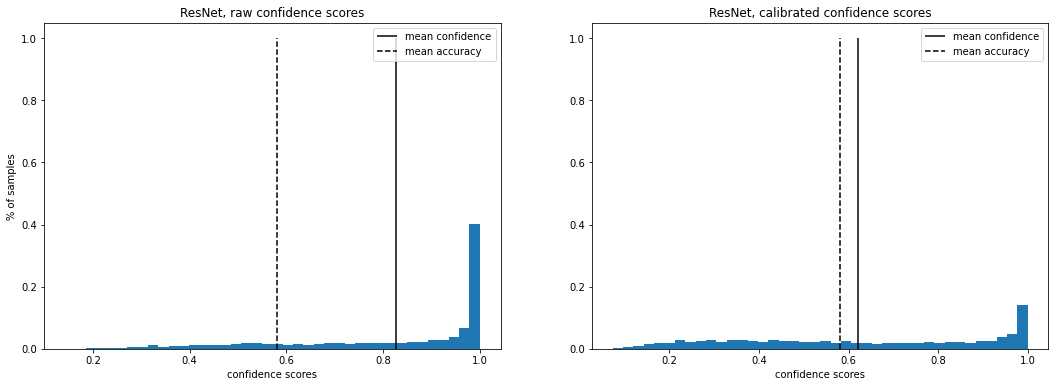

In [ ]:
resnet_confidence, labels = labels_and_probabilities(test_loader, resnet50, device)
scaled_resnet_confidence, _ = labels_and_probabilities(test_loader, resnet_scaled, device)


plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
confidence_hist(resnet_confidence, labels, 'ResNet, raw confidence scores', 40)
plt.ylabel('% of samples')
plt.subplot(1,2,2)
confidence_hist(scaled_resnet_confidence, labels, 'ResNet, calibrated confidence scores', 40)
